# Tugas 5 **GRAPH**

Nama : Zainal Arifin

NIM  : 220411100103


#**Install Library**


In [ ]:
!pip install Sastrawi pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re

from tqdm import tqdm

import pickle
import nltk
import networkx as nx
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##**Load Data**


In [ ]:
file_path = '/content/hasil_crawling.csv'
df = pd.read_csv(file_path)
df

,Title,Date,Content,Category
0,Program Cetak Sawah dan Oplah Diyakini Bisa Bi...,Naufal Zuhdi • 15 October 2024 14:27,Jakarta: Guru Besar Universitas Gadjah Mada (U...,Ekonomi
1,53 Bulan Berturut-turut Neraca Perdagangan RI ...,Annisa ayu artanti • 15 October 2024 14:25,,Ekonomi
2,"BI Diprediksi akan Tahan BI Rate Tetap di 6,00%",Annisa Ayu Artanti • 15 October 2024 14:21,,Ekonomi
3,"Ada Pilkada Serentak, 27 November 2024 Jadi Li...",Annisa Ayu Artanti • 15 October 2024 14:18,,Ekonomi
4,Apa Itu Bulan Inklusi Keuangan yang Dirayakan ...,Medcom • 15 October 2024 13:48,"Jakarta: Setiap tahun pada Oktober, Otoritas J...",Ekonomi
...,...,...,...,...
95,Hotel Terapung Siap Penuhi Akomodasi Masyaraka...,Gregorius Gelino • 7 September 2024 16:53,"Banda Aceh: KM Kelud, kapal motor milik PT Pel...",Olahraga
96,Tim Sepak Bola Sumut Jungkalkan Jateng di PON ...,Gregorius Gelino • 7 September 2024 16:14,Banda Aceh: Tim sepak bola Sumatera Utara berh...,Olahraga
97,Natasya Beteyob Pecahkan Rekor Angkat Besi PON,Gregorius Gelino • 7 September 2024 15:48,"Aceh: Natasya Beteyob, lifter muda berbakat as...",Olahraga
98,Timnas Indonesia Punya Sponsor Baru,Gregorius Gelino • 7 September 2024 15:09,"Jakarta: ExtraJoss, minuman energi dari PT Bin...",Olahraga


##**PREPROCESSING**

In [ ]:
def clean_lower(text):
    if isinstance(text, str):
        return text.lower()
    return text

df['lower case'] = df['Content'].apply(clean_lower)

casefolding = pd.DataFrame(df['lower case'])

def clean_punct(text):
    if isinstance(text, str):
        clean_patterns = re.compile(r'[0-9]|[/(){}\[\]\|@,;_]|[^a-z ]')
        text = clean_patterns.sub(' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

df['tanda baca'] = df['lower case'].apply(clean_punct)

def _normalize_whitespace(text):
    if isinstance(text, str):
        corrected = re.sub(r'\s+', ' ', text)
        return corrected.strip()
    return text

df['spasi'] = df['tanda baca'].apply(_normalize_whitespace)

def clean_stopwords(text):
    if isinstance(text, str):
        stopword = set(stopwords.words('indonesian'))
        text = ' '.join(word for word in text.split() if word not in stopword)
        return text.strip()
    return text

df['stopwords'] = df['spasi'].apply(clean_stopwords)

def sastrawistemmer(text):
    factory = StemmerFactory()
    st = factory.create_stemmer()
    text = ' '.join(st.stem(word) for word in tqdm(text.split()) if word in text)
    return text

df['stemming'] = df['stopwords'].apply(sastrawistemmer)

100%|██████████| 128/128 [00:05<00:00, 22.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 91/91 [00:02<00:00, 42.58it/s]
0it [00:00, ?it/s]
100%|██████████| 73/73 [00:03<00:00, 20.97it/s]
0it [00:00, ?it/s]
100%|██████████| 157/157 [00:03<00:00, 40.35it/s]
0it [00:00, ?it/s]
100%|██████████| 80/80 [00:02<00:00, 39.45it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 70/70 [00:00<00:00, 89.98it/s] 
0it [00:00, ?it/s]
100%|██████████| 77/77 [00:02<00:00, 36.46it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 114/114 [00:02<00:00, 46.31it/s]


#Representasi Teks Menggunakan TF-IDF dan Kategori
####Melakukan proses vectorization menggunakan TF-IDF pada teks yang telah di-stem, menambahkan kategori untuk setiap dokumen, dan menyusun hasilnya dalam DataFrame.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
corpus = df['stemming'].tolist()
x_tfidf = tfidf_vectorizer.fit_transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(x_tfidf.toarray(), columns=feature_names)
cat_df = df["Category"]
tfidf_df['Category'] = cat_df.values
tfidf_df = tfidf_df[['Category'] + [col for col in tfidf_df.columns if col != 'Category']]

tfidf_df

,Category,aacm,abadi,abdullah,abimanyu,abraham,absen,acara,aceh,action,...,yuni,yusrizal,yusuf,za,zaman,zamitah,zeki,zero,zona,zone
0,Ekonomi,0.0,0.000000,0.064737,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,Ekonomi,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,Ekonomi,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Ekonomi,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Ekonomi,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Olahraga,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.208922,0.0,...,0.0,0.0,0.0,0.057588,0.0,0.0,0.0,0.0,0.000000,0.0
96,Olahraga,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.126659,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
97,Olahraga,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.062512,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
98,Olahraga,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.025212,0.0


#Menghitung Kemiripan Dokumen Menggunakan Cosine Similarity
####Menghasilkan matriks kemiripan antar dokumen menggunakan cosine similarity berdasarkan representasi TF-IDF, yang dapat digunakan untuk analisis lebih lanjut dalam tugas-tugas seperti pengelompokan atau rekomendasi dokumen.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_values = tfidf_df.drop(columns=['Category'])
adjacency_matrix = cosine_similarity(tfidf_values)

In [ ]:
adjacency_df = pd.DataFrame(adjacency_matrix)
adjacency_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.0,0.0,0.0,0.003090,0.012433,0.022329,0.008813,0.027573,0.029494,...,0.006781,0.011990,0.015440,0.012375,0.025366,0.028240,0.016166,0.007587,0.036215,0.019006
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.003090,0.0,0.0,0.0,1.000000,0.093288,0.015925,0.012307,0.015698,0.005893,...,0.003565,0.004877,0.010601,0.001105,0.007069,0.006305,0.004381,0.002675,0.005689,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.028240,0.0,0.0,0.0,0.006305,0.008100,0.042900,0.031886,0.013782,0.019132,...,0.043541,0.012389,0.012479,0.097813,0.016361,1.000000,0.083483,0.072748,0.052396,0.156836
96,0.016166,0.0,0.0,0.0,0.004381,0.002986,0.016285,0.008615,0.005322,0.049973,...,0.079653,0.083293,0.106386,0.089912,0.175717,0.083483,1.000000,0.063105,0.102819,0.102294
97,0.007587,0.0,0.0,0.0,0.002675,0.004404,0.009275,0.007825,0.006550,0.000537,...,0.113688,0.025566,0.013031,0.051457,0.014495,0.072748,0.063105,1.000000,0.051843,0.058362
98,0.036215,0.0,0.0,0.0,0.005689,0.028766,0.040583,0.010776,0.020566,0.040785,...,0.016572,0.132027,0.055667,0.069310,0.049997,0.052396,0.102819,0.051843,1.000000,0.073466


#Visualisasi Graf Kemiripan Dokumen Menggunakan NetworkX
####Membuat dan memvisualisasikan graf terarah yang menunjukkan kemiripan antara dokumen, dengan node mewakili dokumen dan edge menunjukkan tingkat kemiripan yang cukup signifikan. Visualisasi ini membantu dalam memahami hubungan antar dokumen berdasarkan analisis teks.

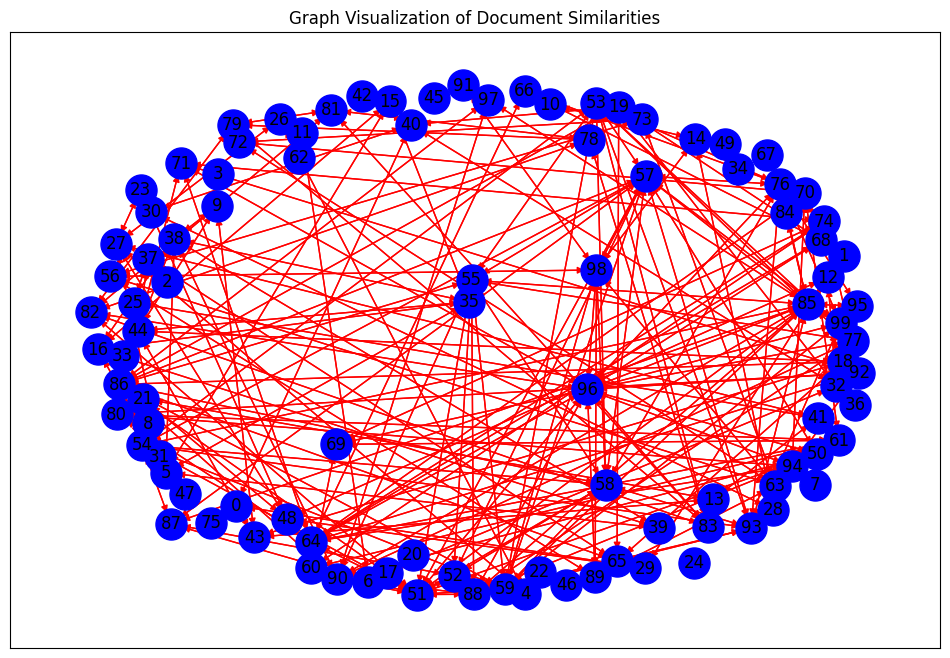

In [ ]:
G_preprocessing = nx.DiGraph()

# Add nodes to the graph
for i in range(len(adjacency_matrix)):
    G_preprocessing.add_node(i)

# Add edges based on cosine similarity threshold of 0.1
for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix)):
        similarity_preprocessing = adjacency_matrix[i][j]
        if similarity_preprocessing > 0.1 and i != j:
            G_preprocessing.add_edge(i, j)

# Generate layout for visualization
pos = nx.spring_layout(G_preprocessing, k=2)

# Draw the nodes, edges, and labels
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_preprocessing, pos, node_size=500, node_color='b')
nx.draw_networkx_edges(G_preprocessing, pos, edge_color='red', arrows=True)
nx.draw_networkx_labels(G_preprocessing, pos)

# Show plot
plt.title("Graph Visualization of Document Similarities")
plt.show()


#Analisis Sentralitas Dokumen dalam Graf Kemiripan
####Menghitung ukuran sentralitas (closeness dan betweenness) untuk dokumen dalam graf terarah, menggabungkannya dalam DataFrame, dan menampilkan lima dokumen teratas berdasarkan nilai sentralitas tersebut. Analisis ini berguna untuk memahami posisi dan peran masing-masing dokumen dalam jaringan kemiripan.

In [ ]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G_preprocessing)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_preprocessing, normalized=True)

# Combine the centrality measures into a DataFrame for easy comparison
centrality_df = pd.DataFrame({
    'Closeness Centrality': closeness_centrality,
    'Betweenness Centrality': betweenness_centrality
})

# Display the top 5 documents with the highest centrality values
centrality_df.sort_values(by=['Closeness Centrality', 'Betweenness Centrality'], ascending=False)


,Closeness Centrality,Betweenness Centrality
51,0.302469,0.098957
86,0.292141,0.120793
96,0.287927,0.138912
90,0.277263,0.121838
57,0.277263,0.034091
...,...,...
47,0.000000,0.000000
49,0.000000,0.000000
62,0.000000,0.000000
67,0.000000,0.000000
